In [196]:
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

import awkward as ak
# import uproot as upr

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

In [197]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    "CSCIT",
    "DTIT",
    "MET",
    # "ME11/12",
    # "MB1",
    "JET",
    # "MUON",
    # "BDT",
    "HALO",
    # "CSCSIZE",
    "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc_l = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal, ME_{t} < 75 GeV", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_mc_h = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal, ME_{t} > 150 GeV", nev=N_EVENTS, is_mc=True, lumi=LUMI)

ms_r3_l = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data OOT, ME_{t} < 75 GeV", nev=N_EVENTS, is_mc=False, lumi=LUMI)
ms_r3_h = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data OOT, ME_{t} > 150 GeV", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)


mss = [ms_mc_l, ms_r3_l, ms_mc_h, ms_r3_h]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    if '<' in msn:
        ms.f((0 <= ms["met"]) & (ms["met"] < 75))
    else:
        ms.f((150 <= ms["met"]) & (ms["met"] < 200))

    ms.cut_l1()

    if 'data oot' in msn:
        # ms.f((ms['cscTimeWeighted'] < -5) | (12.5 < ms['cscTimeWeighted']), 'csc')
        ms.f(ms['dtRechitCluster_match_RPCBx_dPhi0p5'] != 0, 'dt')

    ms.f((ms["nCsc"] > 0) | (ms["nDt"] > 0))
    
    # ms.tag(tags="cscdt")
    # ms.f(ms["tag_dPhi"] > 0.4, invert=False)
    
    # for cut in CUTS:
    #     match cut:
    #         case "match":
    #             if is_mc:
    #                 ms.match_mc("csc,dt", has_clusters=True)
    #         case "HLT":
    #             # if not is_mc:
    #             #     ms.cut_hlt()
    #             pass  #! Loading TBranch HLTDecision causes memory overflow so I use a precut TTree
    #         case "CSC&DT>0":
    #             ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
    #         case "L1":
    #             ms.cut_l1()
    #         case "CSCIT":
    #             ms.cut_time("csc", invert="csc oot" in msn)
    #         case "DTIT":
    #             ms.cut_time("dt", invert="dt oot" in msn)
    #         case "MET":
    #             ms.f((0 <= ms["met"]) & (ms["met"] < 200))
    #         case "ME11/12":
    #             ms.f(
    #                 ms["cscNRechitChamberPlus11"]
    #                 + ms["cscNRechitChamberMinus11"]
    #                 + ms["cscNRechitChamberPlus12"]
    #                 + ms["cscNRechitChamberMinus12"]
    #                 == 0,
    #                 "csc",
    #             )
    #         case "MB1":
    #             ms.f(ms["dtNHitStation1"] < 10, "dt")
    #         case "JET":
    #             # ms.cut_jet("csc,dt")
    #             ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
    #             # ms.cut_jet("dt")
    #         case "MUON":
    #             ms.cut_muon("csc,dt")
    #         case "BDT":
    #             pass
    #         case "HALO":
    #             ms.cut_halo(invert=False)  #! HALO CUT
    #         case "CSCSIZE":
    #             # ms.f(ms["cscSize"] > 250, "csc")
    #             ms.f(ms["cscSize"] > 200, "csc")
    #         case "DTSIZE":
    #             ms.f(ms["dtSize"] < 200, "dt")
    #         case "CSCSTN":
    #             ms.f(ms["cscSize"] > 250, "csc")
    #         case "DTSTN":
    #             ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
    #         case "1CSC1DT":
    #             ms.tag(tags="cscdt")
    #         case "BLINDSR":
    #             if not is_mc:
    #                 ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
    #         case "DR":
    #             ms.f(ms["tag_dR"] > 0.5)
    #         case "DPHI":
    #             ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{msn:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]

Building MuonSystemAwkward 'Signal, ME_{t} < 75 GeV' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Signal, ME_{t} > 150 GeV' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data OOT, ME_{t} < 75 GeV' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events
Building MuonSystemAwkward 'Data OOT, ME_{t} > 150 GeV' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events

   signal, me_{t} < 75 gev : 55,355

In [198]:
def optimize(vs, vb, thresholds, goal='s2b', weighted=None, **kwargs):
    if weighted is None:
        weighted = isinstance(vs, tuple)
    if weighted:
        ws, vs = vs[0], vs[1]
        wb, vb = vb[0], vb[1]
    else:
        ws = ak.ones_like(vs)
        wb = ak.ones_like(vb)

    f1_beta = kwargs['f1_beta'] if 'f1_beta' in kwargs else 1
    order = kwargs['order'] if 'order' in kwargs else '>'

    if 'gsel' in kwargs:
        gs, gb = kwargs['gsel'](vs), kwargs['gsel'](vb)
        ws, vs = ws[gs], vs[gs]
        wb, vb = wb[gb], vb[gb]
        del gs, gb

    match goal:
        case 's2b':
            loss_func = lambda s, b: ak.sum(s) / ( ak.sum(b)**(1/2) )
        case 'bce':
            loss_func = lambda s, b: np.log(ak.mean(s)) - np.log(ak.mean(b))
            # loss_func = lambda s, b: np.log(ak.mean(s)) - np.log(1-ak.mean(b))
            # loss_func = lambda s, b: np.log(ak.sum(s)) - np.log(ak.sum(b))
        case 'f1':
            loss_func = lambda s, b: (1+f1_beta**2) * ak.sum(s) / ( \
                                        (1+f1_beta**2) * ak.sum(s)+ \
                                        (f1_beta**2) * ak.sum(b)+ \
                                        ak.sum(~s) )
        case None:
            raise

    roc = []
    best_loss, best_thresh = 0, None
    for th in thresholds:
        if order == '>':
            s, b = (ws*vs)>th, (wb*vb)>th
        elif order == '<':
            s, b = (ws*vs)<th, (wb*vb)<th

        tp, tn, fp, fn = ak.sum(s), ak.sum(~b), ak.sum(b), ak.sum(~s)
        if tp>0 and fp>0:
            l = loss_func(s, b)
            if l > best_loss:
                best_loss, best_thresh = l, th
            roc.append([th,fp/(fp+tn),tp/(tp+fn)])
    roc = np.array(roc)
    return best_loss, best_thresh, roc


# CSC Time

MIN_CSC_TIME_L=-1.75, MAX_CSC_TIME_L=1.50
MIN_CSC_TIME_H=-1.75, MAX_CSC_TIME_H=0.500


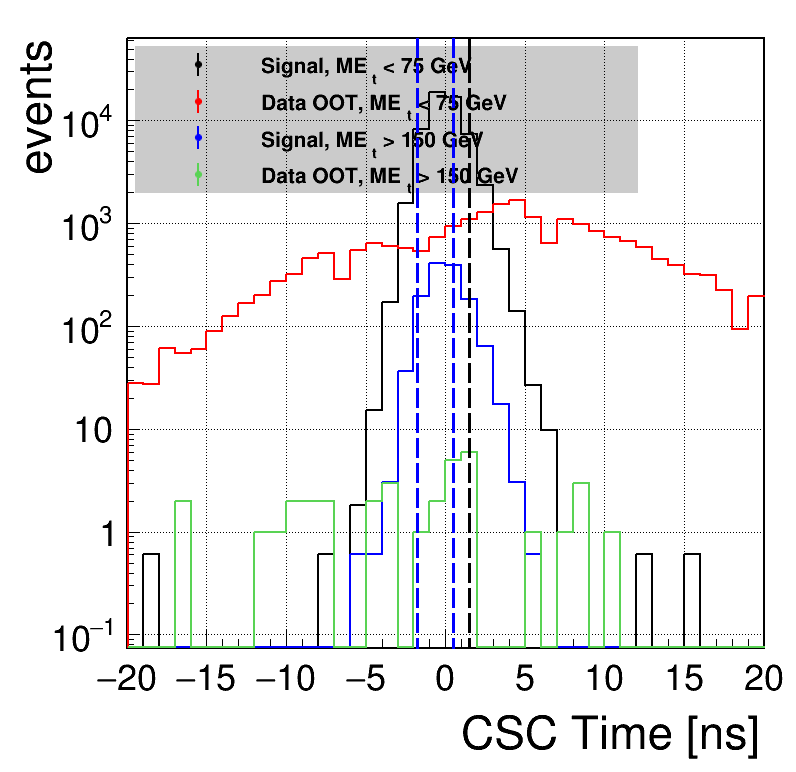

In [214]:
MIN_CSC_TIME_L, MAX_CSC_TIME_L = -5, 12.5#None, None
MIN_CSC_TIME_H, MAX_CSC_TIME_H = -5, 12.5#None, None

# --- #
bins, log, norm = [40,-20,20], True, False
# bins, log, norm = [40,-20,20], False, True
axis_titles = ['CSC Time [ns]', f'{"fraction of " if norm else ""}events']
values = [ms['cscTimeWeighted'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths_lt, ths_gt = np.linspace(bins[1],0,81), np.linspace(0,bins[2],81)
s2b_ll, th_ll, roc_ll = optimize(_v[0], _v[1], ths_lt, gsel=lambda x: x<0, order='>')
s2b_lg, th_lg, roc_lg = optimize(_v[0], _v[1], ths_gt, gsel=lambda x: x>=0, order='<')
s2b_hl, th_hl, roc_hl = optimize(_v[2], _v[3], ths_lt, gsel=lambda x: x<0, order='>')
s2b_hg, th_hg, roc_hg = optimize(_v[2], _v[3], ths_gt, gsel=lambda x: x>=0, order='<')

MIN_CSC_TIME_L, MAX_CSC_TIME_L = th_ll, th_lg
MIN_CSC_TIME_H, MAX_CSC_TIME_H = th_hl, th_hg

print(f'{MIN_CSC_TIME_L=:.2f}, {MAX_CSC_TIME_L=:.2f}')#, {s2b_ll=:.2f}, {s2b_lg=:.2f}')
print(f'{MIN_CSC_TIME_H=:.2f}, {MAX_CSC_TIME_H=:.3f}')#, {s2b_hl=:.2f}, {s2b_hg=:.2f}')

# --- #
lines = [rt.TLine(MIN_CSC_TIME_L, 0, MIN_CSC_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MAX_CSC_TIME_L, 0, MAX_CSC_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MIN_CSC_TIME_H, 0, MIN_CSC_TIME_H, hists[0].GetMaximum()),
         rt.TLine(MAX_CSC_TIME_H, 0, MAX_CSC_TIME_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[(iline//2)*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()

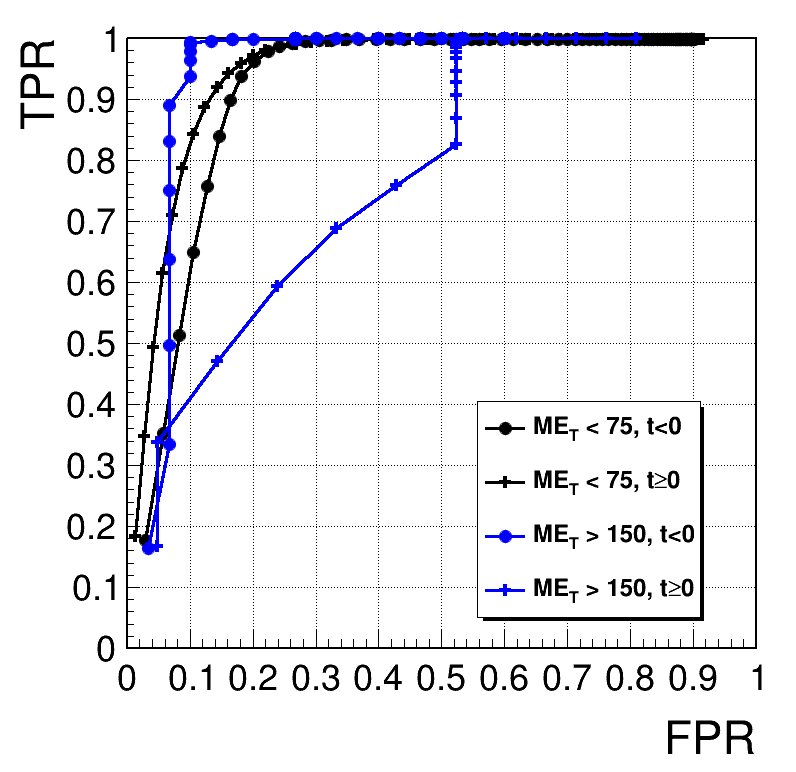

In [213]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.48)

rocs = [roc_ll, roc_lg, roc_hl, roc_hg]
labels = ['ME_{T} < 75, t<0', 'ME_{T} < 75, t#geq0', 'ME_{T} > 150, t<0', 'ME_{T} > 150, t#geq0']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i//2])
    gr.SetMarkerSize(1.5)
    gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()


# DT Time

MIN_DT_TIME_L=-0.50, MAX_DT_TIME_L=0.50
MIN_DT_TIME_H=-0.50, MAX_DT_TIME_H=0.500


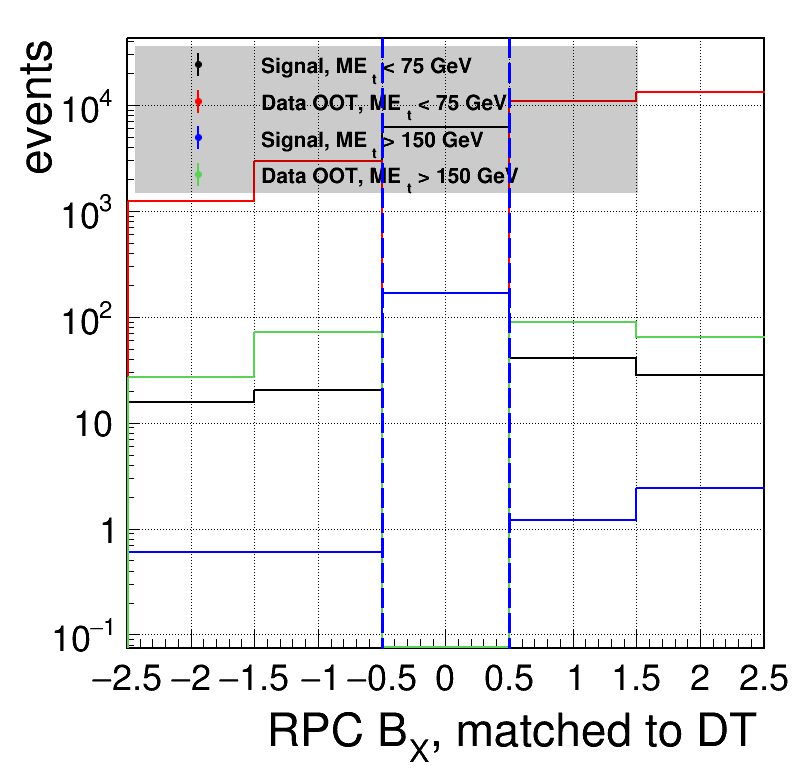

In [201]:
MIN_DT_TIME_L, MAX_DT_TIME_L = -0.5, 0.5#None, None
MIN_DT_TIME_H, MAX_DT_TIME_H = -0.5, 0.5#None, None

# --- #
bins, log, norm = [5,-2.5,2.5], True, False
# bins, log, norm = [5,-2.5,2.5], False, True
axis_titles = ['RPC B_{X}, matched to DT', f'{"fraction of " if norm else ""}events']
values = [ms['dtRechitCluster_match_RPCBx_dPhi0p5'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l[ow met]l[ess than 0])
# ths_lt, ths_gt = np.linspace(bins[1],0,6), np.linspace(0,bins[2],6)
# s2b_ll, th_ll, roc_ll = optimize(_v[0], _v[1], ths_lt, gsel=lambda x: x<0, order='>')
# s2b_lg, th_lg, roc_lg = optimize(_v[0], _v[1], ths_gt, gsel=lambda x: x>=0, order='<')
# s2b_hl, th_hl, roc_hl = optimize(_v[2], _v[3], ths_lt, gsel=lambda x: x<0, order='>')
# s2b_hg, th_hg, roc_hg = optimize(_v[2], _v[3], ths_gt, gsel=lambda x: x>=0, order='<')

# MIN_DT_TIME_L, MAX_DT_TIME_L = th_ll, th_lg
# MIN_DT_TIME_H, MAX_DT_TIME_H = th_hl, th_hg

print(f'{MIN_DT_TIME_L=:.2f}, {MAX_DT_TIME_L=:.2f}')#, {s2b_ll=:.2f}, {s2b_lg=:.2f}')
print(f'{MIN_DT_TIME_H=:.2f}, {MAX_DT_TIME_H=:.3f}')#, {s2b_hl=:.2f}, {s2b_hg=:.2f}')

# --- #
lines = [rt.TLine(MIN_DT_TIME_L, 0, MIN_DT_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MAX_DT_TIME_L, 0, MAX_DT_TIME_L, hists[0].GetMaximum()),
         rt.TLine(MIN_DT_TIME_H, 0, MIN_DT_TIME_H, hists[0].GetMaximum()),
         rt.TLine(MAX_DT_TIME_H, 0, MAX_DT_TIME_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[(iline//2)*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()
canvas.Draw()

In [202]:
# canvas = rt.TCanvas('','',800,800)
# canvas.SetGrid()

# legend = rt.TLegend(0.6, 0.2, 0.88, 0.48)

# rocs = [roc_ll, roc_lg, roc_hl, roc_hg]
# labels = ['MET < 75, t<0', 'MET < 75, t>0', 'MET > 150, t<0', 'MET > 150, t>0']

# for i, (roc, label) in enumerate(zip(rocs, labels)):
#     ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
#     gr = rt.TGraph(len(fpr), fpr, tpr)
#     gr.SetName(label)
#     gr.SetTitle(';FPR;TPR')
#     gr.SetMinimum(0)
#     gr.SetMaximum(1)
#     gr.GetXaxis().SetLimits(0, 1)

#     gr.SetLineWidth(3)
#     gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i//2])
#     gr.SetMarkerSize(1.5)
#     gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
#     gr.SetMarkerColor(gr.GetLineColor())

#     gr.Draw(('' if i else 'A') + ' LP')
#     legend.AddEntry(gr, gr.GetName(), 'LP')
#     gc.append(gr)

# legend.Draw()
# canvas.Draw()

print('skipping, just use bx=0')

skipping, just use bx=0


# DT MB1

MAX_MB1_L=100.00, s2b_l=35.83
MAX_MB1_H=1.00, s2b_h=17.22


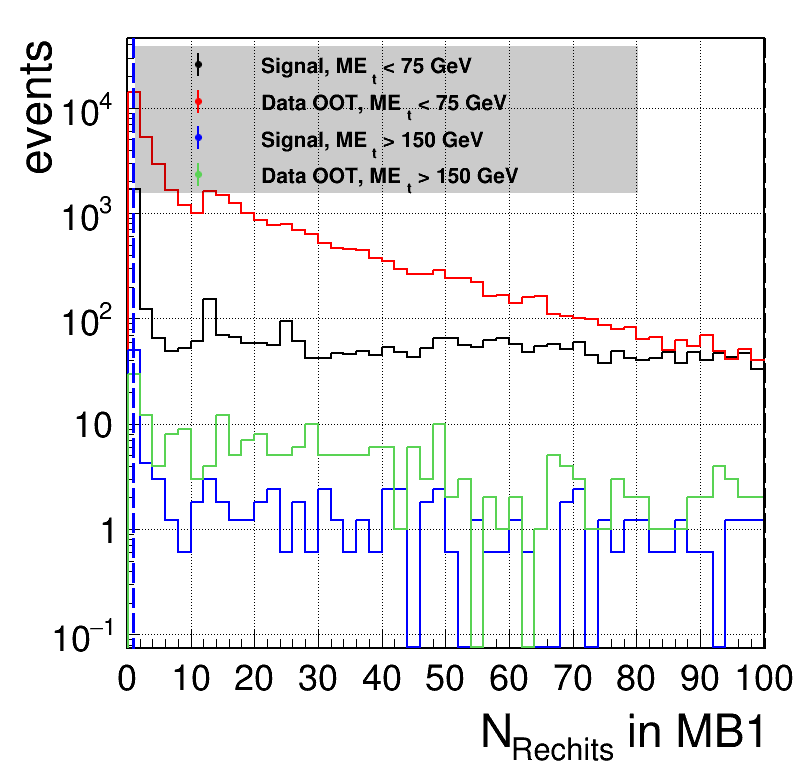

In [217]:
MAX_MB1_L, MAX_MB1_H = None, None

# --- #
bins, log, norm = [50, 0, 100], True, False
# bins, log, norm = [50, 0, 100], False, True
axis_titles = ['N_{Rechits} in MB1', f'{"fraction of " if norm else ""}events']
# values = [ms['dtRechitCluster_match_MB1hits_0p4'] for ms in mss]
values = [ms['dtNHitStation1'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths= np.linspace(bins[1],bins[2],bins[2]-bins[1]+1)
s2b_l, th_l, roc_l = optimize(_v[0], _v[1], ths, order='<')
s2b_h, th_h, roc_h = optimize(_v[2], _v[3], ths, order='<')

MAX_MB1_L, MAX_MB1_H = th_l, th_h

print(f'{MAX_MB1_L=:.2f}, {s2b_l=:.2f}')
print(f'{MAX_MB1_H=:.2f}, {s2b_h=:.2f}')

# --- #
lines = [rt.TLine(MAX_MB1_L, 0, MAX_MB1_L, hists[0].GetMaximum()),
         rt.TLine(MAX_MB1_H, 0, MAX_MB1_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[iline*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()

print('a cut of nhits<10 could be good because there seems to be a small increase in oot data events after this. maybe punchthrough jets create >10 hits')

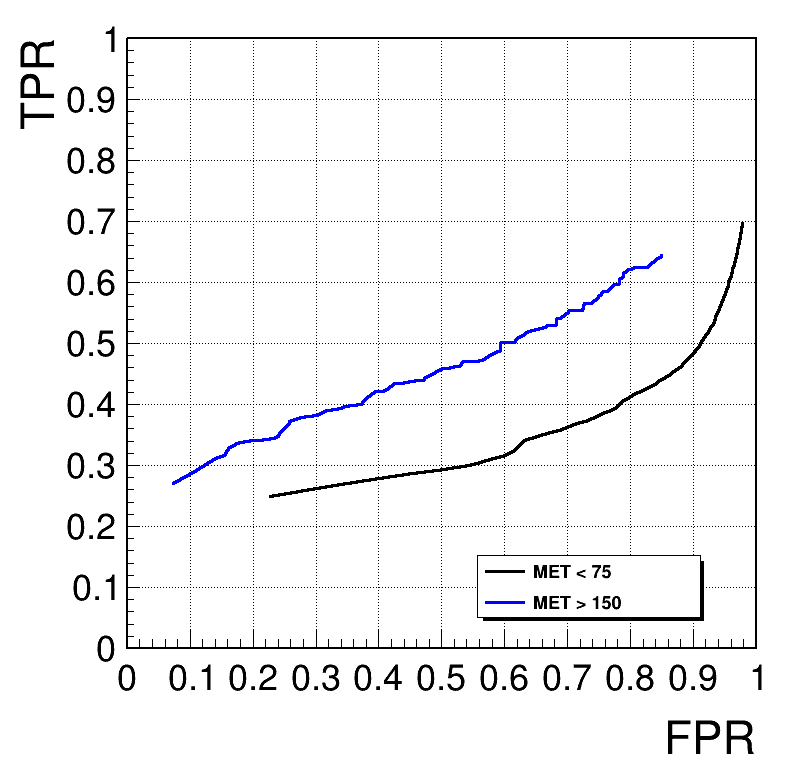

In [204]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.28)

rocs = [roc_l, roc_h]
labels = ['MET < 75', 'MET > 150']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i])
    gr.SetMarkerSize(0)#1.5)
    # gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()

MAX_MB1_RATIO_L=0.60, s2b_l=126.43
MAX_MB1_RATIO_H=0.52, s2b_h=25.86
not sure what to think of this one. if anything im tempted to say no hits in mb1 OR more than half need to be in mb1


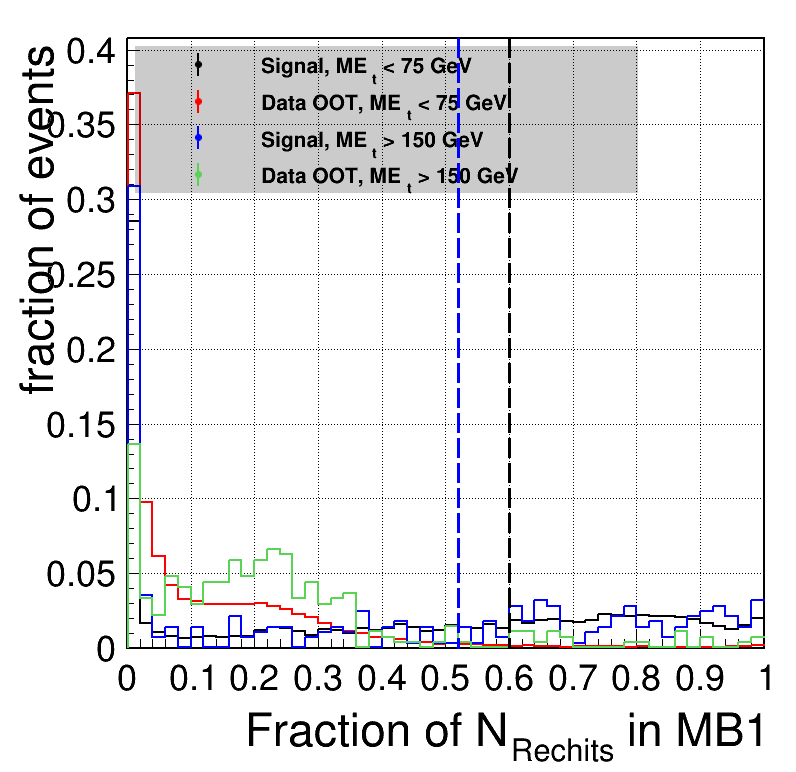

In [235]:
MAX_MB1_RATIO_L, MAX_MB1_RATIO_H = None, None

# --- #
bins, log, norm = [50,0, 1], True, False
# bins, log, norm = [50, 0, 1], False, True
axis_titles = ['Fraction of N_{Rechits} in MB1', f'{"fraction of " if norm else ""}events']
values = [ms['dtNHitStation1'] / ms['dtSize'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths= np.linspace(bins[1],bins[2],51)
s2b_l, th_l, roc_l = optimize(_v[0], _v[1], ths, order='>')
s2b_h, th_h, roc_h = optimize(_v[2], _v[3], ths, order='>')

MAX_MB1_RATIO_L, MAX_MB1_RATIO_H = th_l, th_h

print(f'{MAX_MB1_RATIO_L=:.2f}, {s2b_l=:.2f}')
print(f'{MAX_MB1_RATIO_H=:.2f}, {s2b_h=:.2f}')

# --- #
lines = [rt.TLine(MAX_MB1_RATIO_L, 0, MAX_MB1_RATIO_L, hists[0].GetMaximum()),
         rt.TLine(MAX_MB1_RATIO_H, 0, MAX_MB1_RATIO_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[iline*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()

print('not sure what to think of this one. if anything im tempted to say no hits in mb1 OR more than half need to be in mb1')

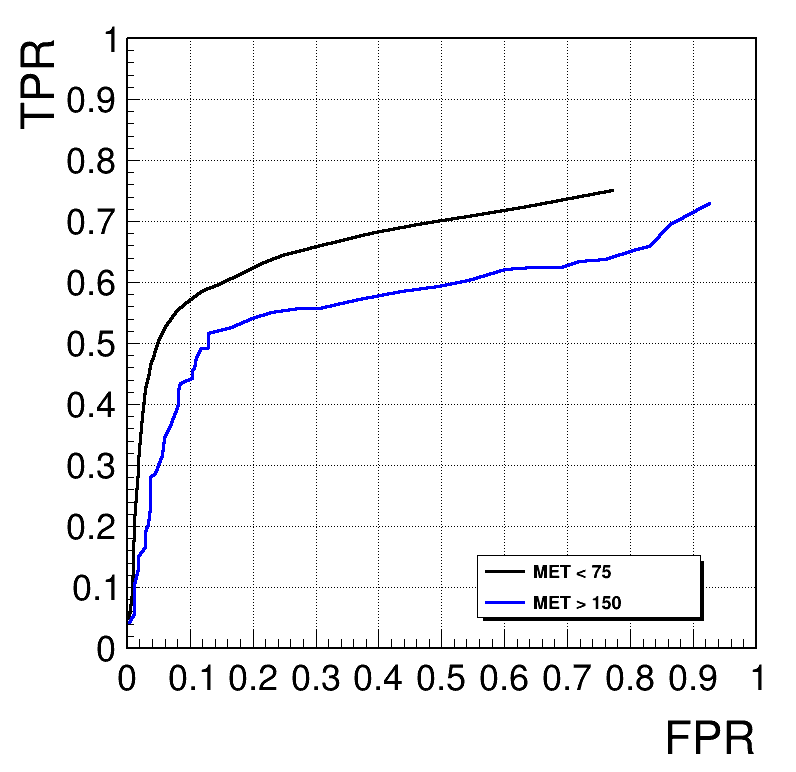

In [222]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.28)

rocs = [roc_l, roc_h]
labels = ['MET < 75', 'MET > 150']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i])
    gr.SetMarkerSize(0)#1.5)
    # gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()

# CSC Jet

MAX_CSC_JET_PT_L=1.00, s2b_l=680.86
MAX_CSC_JET_PT_H=1.00, s2b_h=441.52


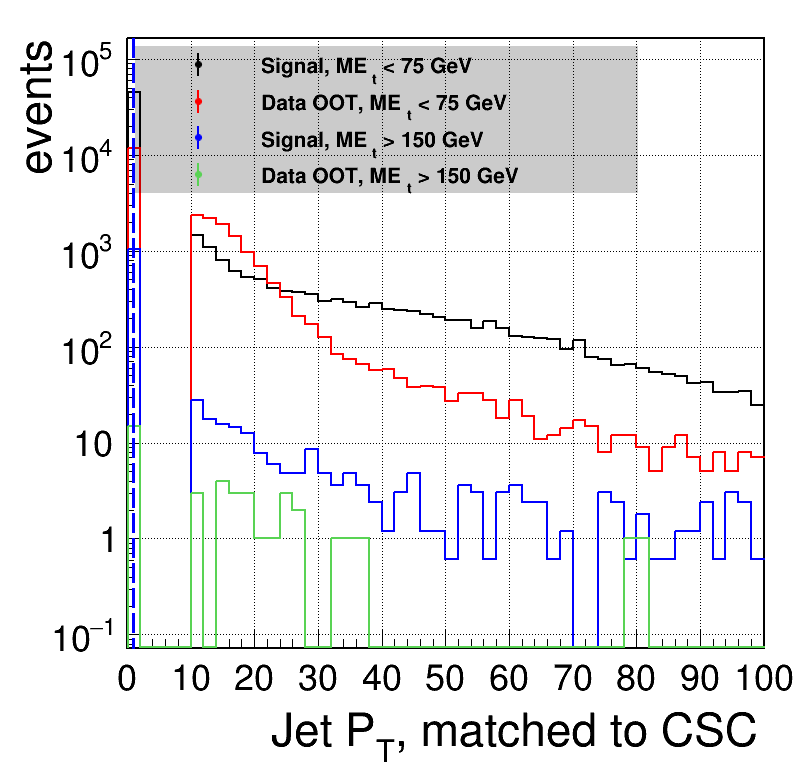

In [240]:
MAX_CSC_JET_PT_L, MAX_CSC_JET_PT_H = None, None

# --- #
bins, log, norm = [50,0, 100], True, False
# bins, log, norm = [50,0, 100], False, True
axis_titles = ['Jet P_{T}, matched to CSC', f'{"fraction of " if norm else ""}events']
values = [ms['cscRechitClusterJetVetoPt'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths= np.linspace(bins[1],bins[2],101)
s2b_l, th_l, roc_l = optimize(_v[0], _v[1], ths, order='<')
s2b_h, th_h, roc_h = optimize(_v[2], _v[3], ths, order='<')

MAX_CSC_JET_PT_L, MAX_CSC_JET_PT_H = th_l, th_h

print(f'{MAX_CSC_JET_PT_L=:.2f}, {s2b_l=:.2f}')
print(f'{MAX_CSC_JET_PT_H=:.2f}, {s2b_h=:.2f}')

# --- #
lines = [rt.TLine(MAX_CSC_JET_PT_L, 0, MAX_CSC_JET_PT_L, hists[0].GetMaximum()),
         rt.TLine(MAX_CSC_JET_PT_H, 0, MAX_CSC_JET_PT_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[iline*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()

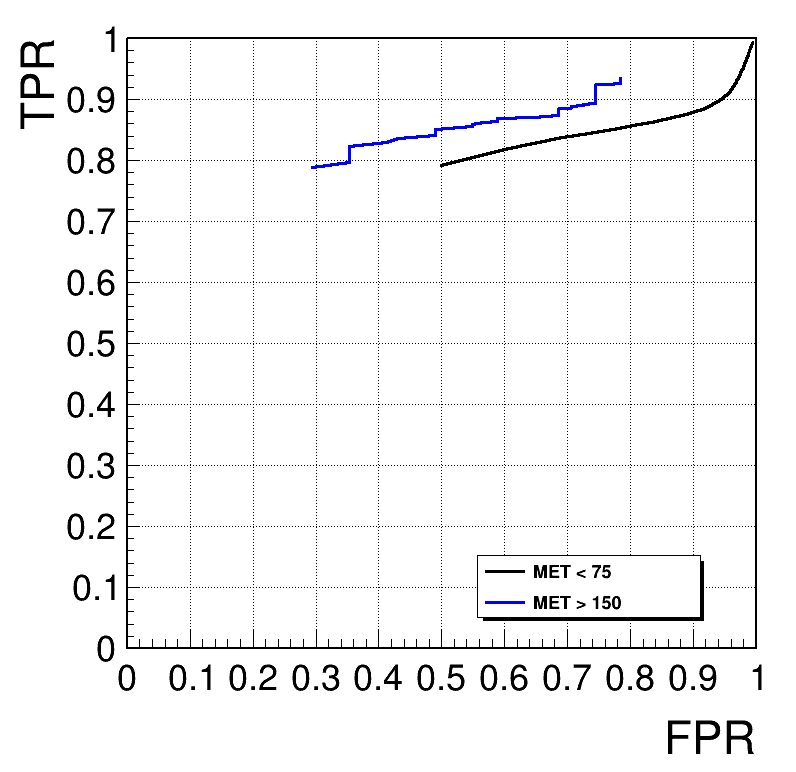

In [241]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.28)

rocs = [roc_l, roc_h]
labels = ['MET < 75', 'MET > 150']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i])
    gr.SetMarkerSize(0)#1.5)
    # gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()

# DT Jet

MAX_DT_JET_PT_L=100.00, s2b_l=50.25
MAX_DT_JET_PT_H=1.00, s2b_h=17.46


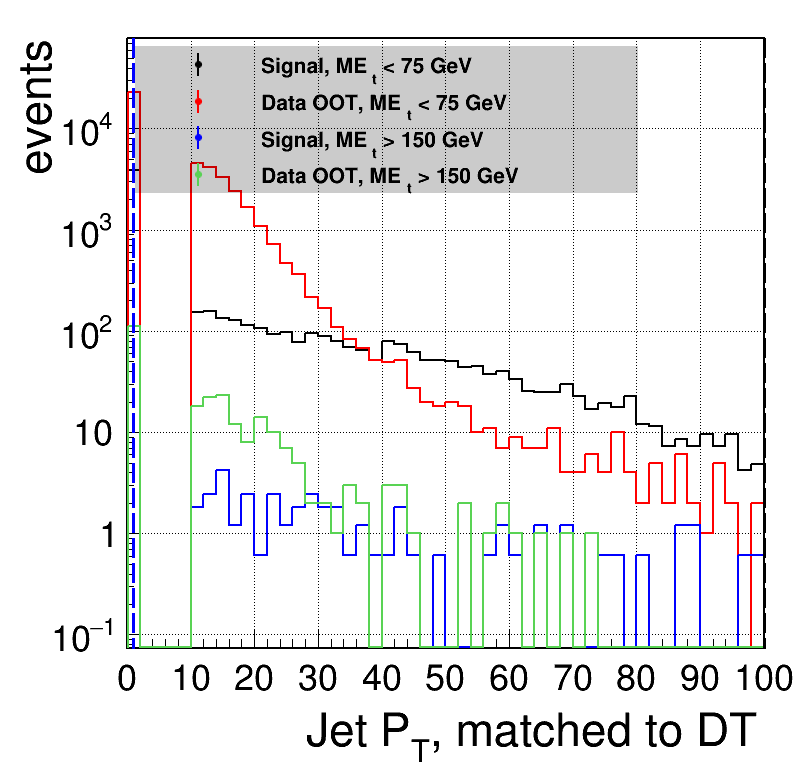

In [242]:
MAX_DT_JET_PT_L, MAX_DT_JET_PT_H = None, None

# --- #
bins, log, norm = [50,0, 100], True, False
# bins, log, norm = [50,0, 100], False, True
axis_titles = ['Jet P_{T}, matched to DT', f'{"fraction of " if norm else ""}events']
values = [ms['dtRechitClusterJetVetoPt'] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths= np.linspace(bins[1],bins[2],101)
s2b_l, th_l, roc_l = optimize(_v[0], _v[1], ths, order='<')
s2b_h, th_h, roc_h = optimize(_v[2], _v[3], ths, order='<')

MAX_DT_JET_PT_L, MAX_DT_JET_PT_H = th_l, th_h

print(f'{MAX_DT_JET_PT_L=:.2f}, {s2b_l=:.2f}')
print(f'{MAX_DT_JET_PT_H=:.2f}, {s2b_h=:.2f}')

# --- #
lines = [rt.TLine(MAX_DT_JET_PT_L, 0, MAX_DT_JET_PT_L, hists[0].GetMaximum()),
         rt.TLine(MAX_DT_JET_PT_H, 0, MAX_DT_JET_PT_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[iline*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()

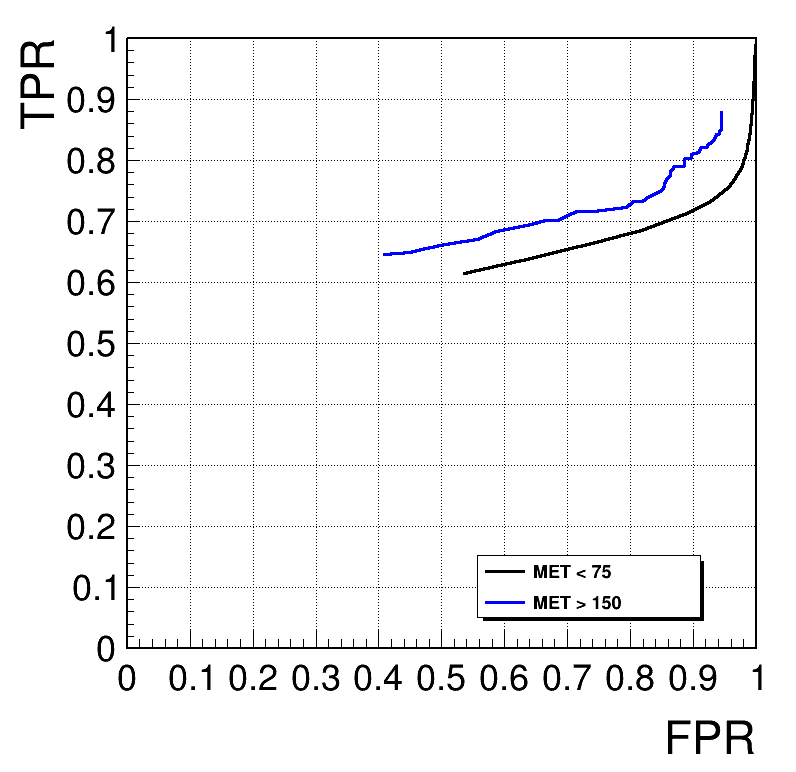

In [243]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.28)

rocs = [roc_l, roc_h]
labels = ['MET < 75', 'MET > 150']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i])
    gr.SetMarkerSize(0)#1.5)
    # gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()

# Halo

MIN_DT_PHI_L=0.05, MAX_DT_PHI_L=3.09
MIN_DT_PHI_H=0.00, MAX_DT_PHI_H=3.142
OPTIMIZE THIS CUT WITH IN-TIME DATA
halo cut not needed for met>150?


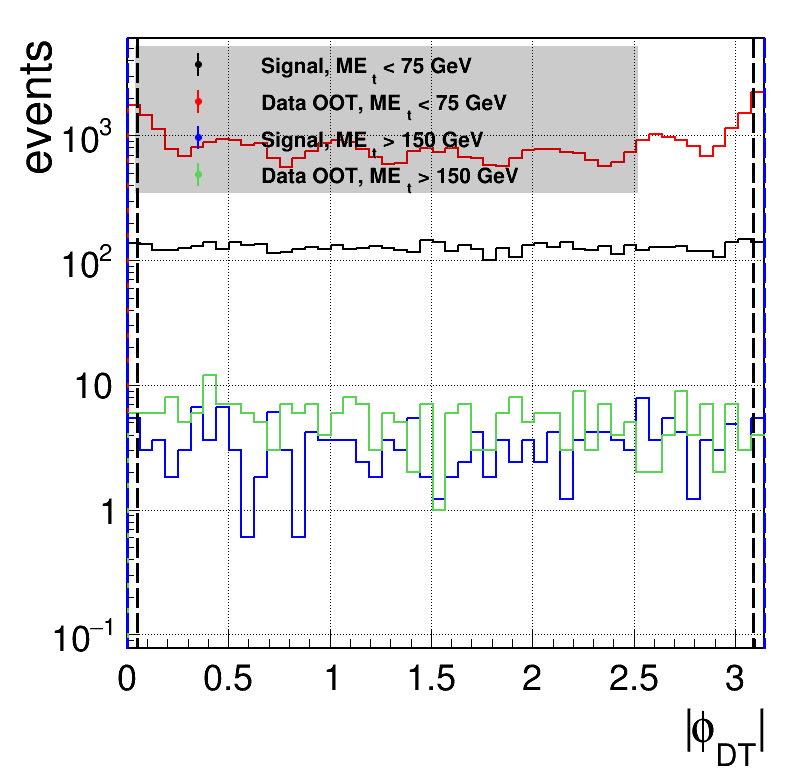

In [266]:
MIN_DT_PHI_L, MAX_DT_PHI_L = None, None
MIN_DT_PHI_H, MAX_DT_PHI_H = None, None

# --- #
bins, log, norm = [50, 0, np.pi], True, False
# bins, log, norm = [16,0, np.pi], False, True
axis_titles = ['|#phi_{DT}|', f'{"fraction of " if norm else ""}events']
values = [np.abs(ms['dtPhi']) for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# --- #
# {criteria}_{met category}{cut category} (eg s2b_l(ow met)l(ess than 0))
ths_lt, ths_gt = np.linspace(bins[1],np.pi/2,32), np.linspace(np.pi/2,bins[2],32)
s2b_ll, th_ll, roc_ll = optimize(_v[0], _v[1], ths_lt, gsel=lambda x: x<np.pi/2, order='>')
s2b_lg, th_lg, roc_lg = optimize(_v[0], _v[1], ths_gt, gsel=lambda x: x>=np.pi/2, order='<')
s2b_hl, th_hl, roc_hl = optimize(_v[2], _v[3], ths_lt, gsel=lambda x: x<np.pi/2, order='>')
s2b_hg, th_hg, roc_hg = optimize(_v[2], _v[3], ths_gt, gsel=lambda x: x>=np.pi/2, order='<')

MIN_DT_PHI_L, MAX_DT_PHI_L = th_ll, th_lg
MIN_DT_PHI_H, MAX_DT_PHI_H = th_hl, th_hg

print(f'{MIN_DT_PHI_L=:.2f}, {MAX_DT_PHI_L=:.2f}')#, {s2b_ll=:.2f}, {s2b_lg=:.2f}')
print(f'{MIN_DT_PHI_H=:.2f}, {MAX_DT_PHI_H=:.3f}')#, {s2b_hl=:.2f}, {s2b_hg=:.2f}')

# --- #
lines = [rt.TLine(MIN_DT_PHI_L, 0, MIN_DT_PHI_L, hists[0].GetMaximum()),
         rt.TLine(MAX_DT_PHI_L, 0, MAX_DT_PHI_L, hists[0].GetMaximum()),
         rt.TLine(MIN_DT_PHI_H, 0, MIN_DT_PHI_H, hists[0].GetMaximum()),
         rt.TLine(MAX_DT_PHI_H, 0, MAX_DT_PHI_H, hists[0].GetMaximum())
]

for iline, line, in enumerate(lines):
    line.SetLineColor(hists[(iline//2)*2].GetLineColor())
    line.SetLineStyle(9)
    line.SetLineWidth(3)
    line.Draw()

canvas.Draw()
print('OPTIMIZE THIS CUT WITH IN-TIME DATA')
print('halo cut not needed for met>150?')
print('0.4 still looks best for met<75')

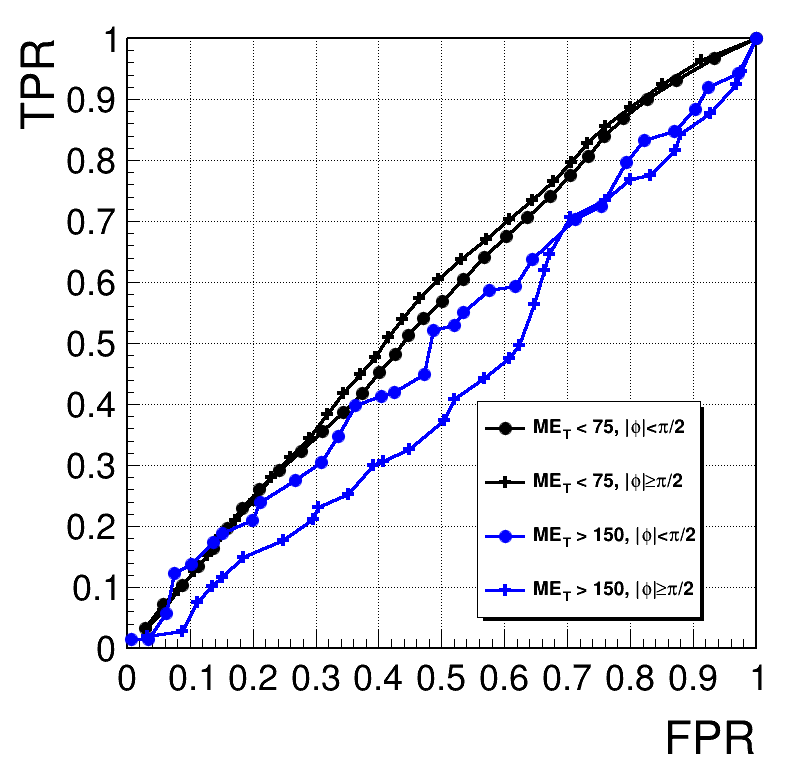

In [260]:
canvas = rt.TCanvas('','',800,800)
canvas.SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.88, 0.48)

rocs = [roc_ll, roc_lg, roc_hl, roc_hg]
labels = ['ME_{T} < 75, |#phi|<#pi/2', 'ME_{T} < 75, |#phi|#geq#pi/2', 'ME_{T} > 150, |#phi|<#pi/2', 'ME_{T} > 150, |#phi|#geq#pi/2']

for i, (roc, label) in enumerate(zip(rocs, labels)):
    ths, fpr, tpr = roc[:,0]*1., roc[:,1]*1., roc[:,2]*1.
    gr = rt.TGraph(len(fpr), fpr, tpr)
    gr.SetName(label)
    gr.SetTitle(';FPR;TPR')
    gr.SetMinimum(0)
    gr.SetMaximum(1)
    gr.GetXaxis().SetLimits(0, 1)

    gr.SetLineWidth(3)
    gr.SetLineColor([hists[0].GetLineColor(), hists[2].GetLineColor()][i//2])
    gr.SetMarkerSize(1.5)
    gr.SetMarkerStyle([rt.kFullCircle, rt.kFullCross][i % 2])
    gr.SetMarkerColor(gr.GetLineColor())

    gr.Draw(('' if i else 'A') + ' LP')
    legend.AddEntry(gr, gr.GetName(), 'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()
